# House Prices: Advanced Regression Techniques

<a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques">Link to competition on Kaggle</a>

This notebook draws inspiration from the following Kaggle Kernels:
- <a href="https://www.kaggle.com/apapiu/regularized-linear-models">Regularized Linear Models</a>
- <a href="https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python/notebook">Comprehensive Data Exploration with Python</a>

At the time of submission, the final model scored in the top 16<sup>th</sup> percentile on the public leaderboard.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_style("whitegrid")
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

%matplotlib inline
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (16, 9)

## Data Preparation

Preprocess data and engineer/select features ahead of model training

## Load data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['trainingset'] = True
df_test['trainingset'] = False
df_full = pd.concat([df_train, df_test], sort=False)
df_full.reset_index(drop=True, inplace=True) # Reset to avoid duplicate indices

df_train.shape, df_test.shape

((1460, 82), (1459, 81))

In [3]:
df_full.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,trainingset
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,False
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,False
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,False
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,False
2918,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN,False


## Process target variable

The target 'SalePrice' column is skewed to the right. We can achieve a more normalised distribution by using `np.log1p(price)` as our target (`np.log` will not be able to handle zero-valued inputs, but `np.log1p` will). Once we've made our predictions later, we can obtain the predicted prices in their original form using `np.expm1`).

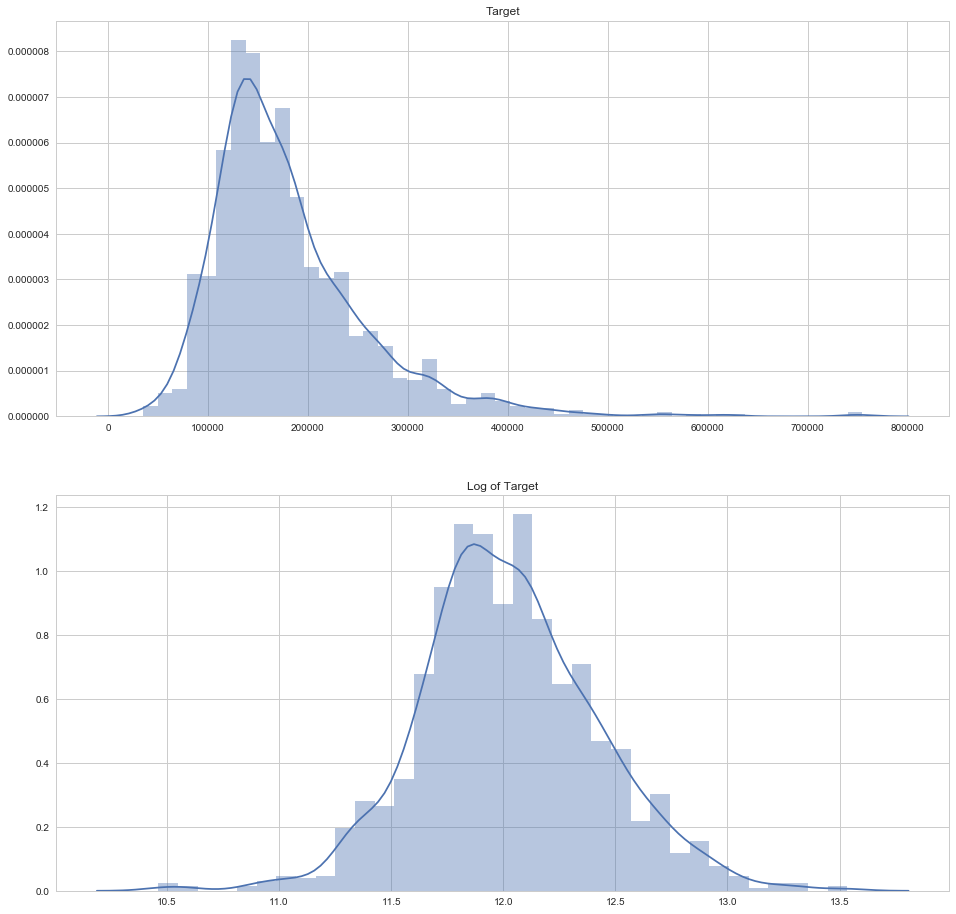

In [4]:
fig, ax = plt.subplots(2, figsize=(16, 16))
sns.distplot(df_train['SalePrice'], ax=ax[0], axlabel=False)
ax[0].set_title('Target')
sns.distplot(df_train['SalePrice'].apply(np.log1p), ax=ax[1], axlabel=False)
ax[1].set_title('Log of Target');

In [5]:
df_full['SalePrice_log'] = np.log1p(df_full['SalePrice'])
df_train['SalePrice_log'] = np.log1p(df_train['SalePrice'])

## Exploration of features

Here we examine the various features and modify them where applicable to achieve better model performance. We will use Lasso regression later, so bar some very obvious candidates, we will not bother removing incomplete or uninformative features at this stage as Lasso will automatically do feature selection. We also address outliers and missing data in this section.

First, we change the data type of 'MSSubClass' to reflect that it's categorical - not numeric.

In [6]:
df_full['MSSubClass'] = df_full['MSSubClass'].astype('O')

Examine the data types of all the columns.

In [7]:
df_full.columns.to_series().groupby(df_full.dtypes).groups

{dtype('bool'): Index(['trainingset'], dtype='object'),
 dtype('int64'): Index(['Id', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
        'GarageCars', 'GarageArea', 'SalePrice', 'SalePrice_log'],
       dtype='object'),
 dtype('O'): Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior

In [8]:
for feature in df_full.columns:
    if df_full[feature].isnull().sum() > 50:
        print(feature, df_full[feature].isnull().sum(), df_full[feature].dtype)

LotFrontage 486 float64
Alley 2721 object
BsmtQual 81 object
BsmtCond 82 object
BsmtExposure 82 object
BsmtFinType1 79 object
BsmtFinType2 80 object
FireplaceQu 1420 object
GarageType 157 object
GarageYrBlt 159 float64
GarageFinish 159 object
GarageQual 159 object
GarageCond 159 object
PoolQC 2909 object
Fence 2348 object
MiscFeature 2814 object
SalePrice 1459 float64
SalePrice_log 1459 float64


### Remove outliers from training set

Feature 'GrLivArea' contains two outliers that are abnormally high for their price. We will discard these rows.

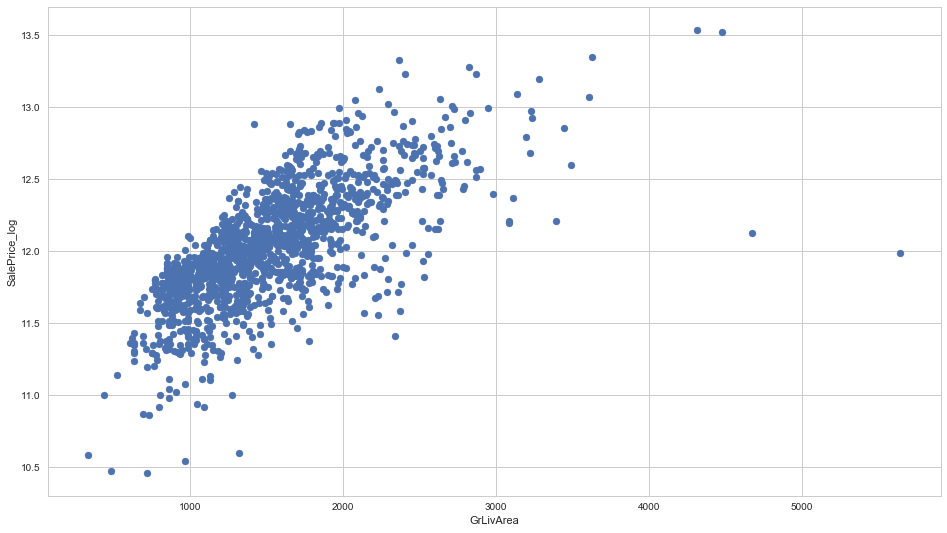

In [9]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice_log'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice_log');

In [10]:
df_full.loc[df_full['trainingset'] == True].sort_values(by='GrLivArea', ascending=False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,trainingset,SalePrice_log
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000.0,True,11.982935
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260.0,Unf,0.0,878.0,3138.0,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1.0,0.0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3.0,884.0,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750.0,True,12.126764


In [11]:
df_full = df_full.drop(df_full[df_full['Id'] == 1299].index)
df_full = df_full.drop(df_full[df_full['Id'] == 524].index)

### Categorical features

Create a convenience function for examining categorical features. We use this to examine all the categorical features, and the ones that warrant modification are discussed below.

In [12]:
def examine_catf(feature, df, target):
    if df[feature].dtype != 'int64':
        df[feature] = df[feature].astype('str')
    vc = df[feature].value_counts(dropna=False)
    print(vc)
    print()
    sns.boxplot(x=feature, y=target, data=df)

Very few houses have a pool - rather than discard this feature, we will convert it to a binary 'hasPool' column.

nan    1453
Gd        3
Fa        2
Ex        2
Name: PoolQC, dtype: int64



C:\Users\aidan\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


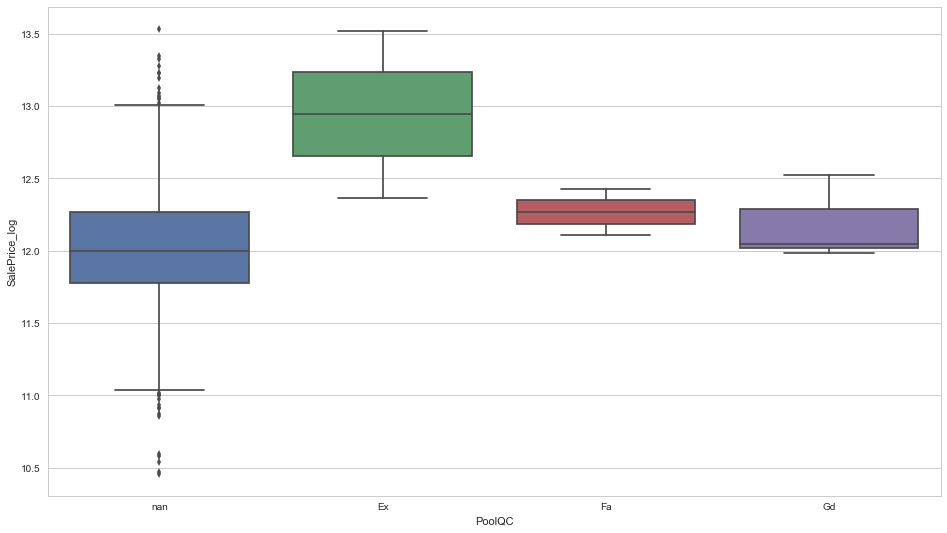

In [13]:
examine_catf('PoolQC', df_train, 'SalePrice_log')

In [14]:
df_full['hasPool'] = df_full['PoolQC'].notnull().astype(int)
df_full.drop('PoolQC', axis=1, inplace=True)

### Numerical features

Most '3SsnPorch' values are zero - may as well convert to a binary feature.

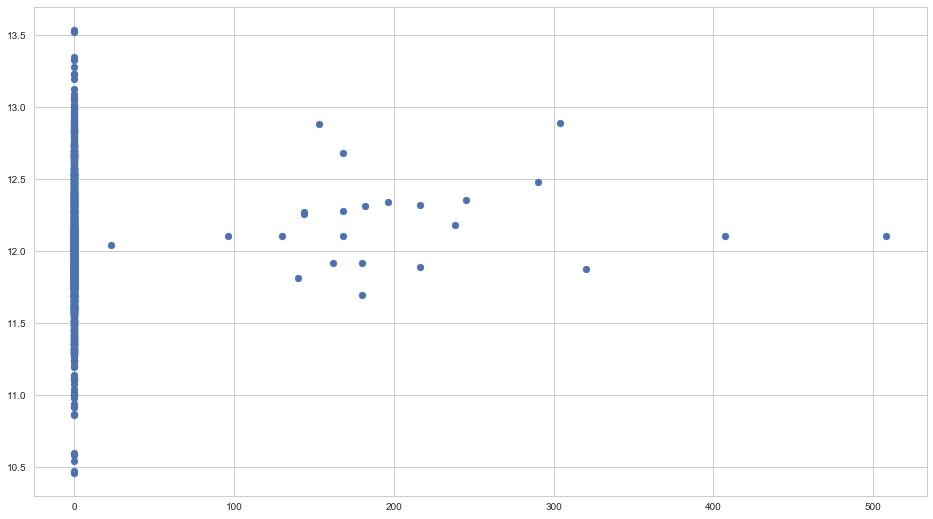

In [15]:
plt.scatter(df_train['3SsnPorch'], df_train['SalePrice_log']);

In [16]:
df_full['has3SsnPorch'] = df_full['3SsnPorch'].notnull().astype(int)
df_full.drop('3SsnPorch', axis=1, inplace=True)

We will log transform numerical features with a signficant skew, as this should achieve better performance for our linear model.

In [17]:
numeric_feats = df_full.dtypes[df_full.dtypes != 'object'].index
skewed_feats = df_full[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats.drop(['SalePrice', 'hasPool'], inplace=True)
skewed_feats

C:\Users\aidan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1060: RuntimeWarning: invalid value encountered in true_divide
  lambda m2, m3: m3 / m2**1.5,


LotFrontage       1.121322
LotArea          13.109495
MasVnrArea        2.609358
BsmtFinSF1        0.980283
BsmtFinSF2        4.143683
BsmtUnfSF         0.919699
1stFlrSF          1.257286
2ndFlrSF          0.861556
LowQualFinSF     12.084539
GrLivArea         1.068750
BsmtHalfBath      3.928397
KitchenAbvGr      4.300550
WoodDeckSF        1.844792
OpenPorchSF       2.529358
EnclosedPorch     4.002344
ScreenPorch       3.945101
PoolArea         17.688664
MiscVal          21.939672
dtype: float64

In [18]:
skewed_feats = skewed_feats.index
df_full[skewed_feats] = np.log1p(df_full[skewed_feats])

### Missing values

Fill missing values for numerical features with the median.

In [19]:
num_cols = df_full.dtypes[df_full.dtypes != 'object'].index
num_cols = num_cols.drop('trainingset')

In [20]:
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='median')
df_full.loc[df_full['trainingset'] == True, num_cols] = imp.fit_transform(df_full.loc[df_full['trainingset'] == True, num_cols])
df_full.loc[df_full['trainingset'] == False, num_cols] = imp.transform(df_full.loc[df_full['trainingset'] == False, num_cols])

With missing values filled, there are further changes that can be made to certain features. 'TotalBsmtSF' is normally distributed, except for the fact that some houses do not have basements, causing a spike at zero. We will create a new feature 'hasBsmt', and log transform the 'TotalBsmtSF' feature where it is not zero, in order to obtain a more normal distribution.

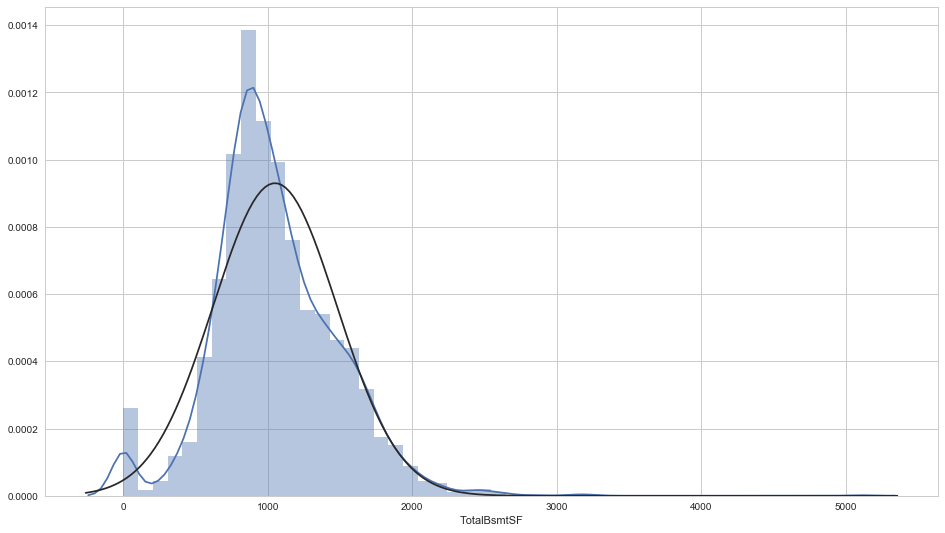

In [21]:
sns.distplot(df_full['TotalBsmtSF'], fit=norm);

C:\Users\aidan\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


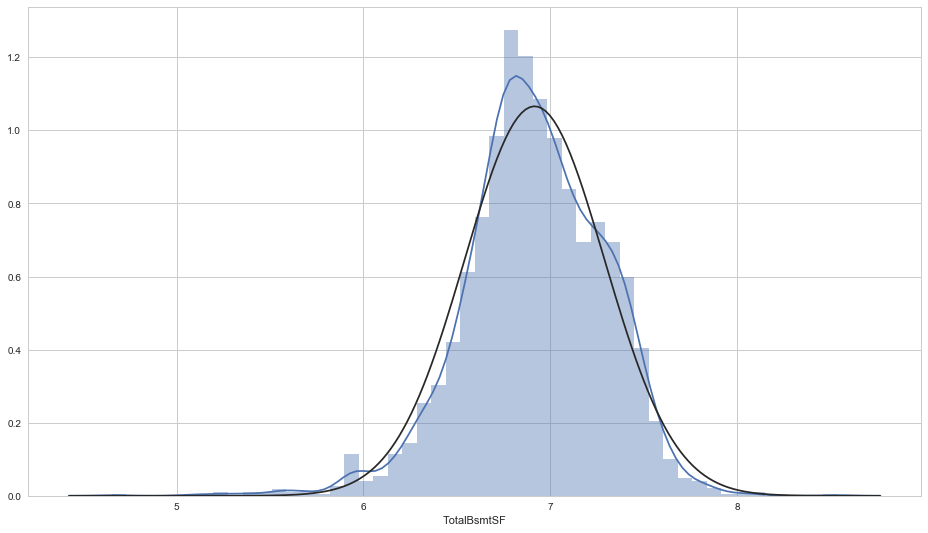

In [22]:
df_full['hasBsmt'] = 0
df_full.loc[df_full['TotalBsmtSF'] > 0, 'hasBsmt'] = 1
df_full.loc[df_full['hasBsmt'] == 1, 'TotalBsmtSF'] = np.log(df_full['TotalBsmtSF'])
sns.distplot(df_full['TotalBsmtSF'][df_full['TotalBsmtSF'] > 0], fit=norm);

## Final preparation of data for models

In [23]:
y = df_full.loc[df_full['trainingset'] == True]['SalePrice_log'].copy()
df_full.drop(['Id', 'SalePrice_log', 'SalePrice'], axis=1, inplace=True)
training = df_full.loc[df_full['trainingset'] == True].copy().drop('trainingset', axis=1)
testing = df_full.loc[df_full['trainingset'] == False].copy().drop('trainingset', axis=1)

In [24]:
num_cols = training.dtypes[training.dtypes != 'object'].index
cat_cols = training.dtypes[training.dtypes == 'object'].index
training[cat_cols] = training[cat_cols].astype(str)
testing[cat_cols] = testing[cat_cols].astype(str)

Create pipeline for data preparation.

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class ConvertToStrings(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.astype(str)

In [26]:
# Definition of the CategoricalEncoder class, copied from PR #9151.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_cols)), 
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_cols)),
    ('strings', ConvertToStrings()),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense",
                                       handle_unknown='ignore'))
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [28]:
X_train = full_pipeline.fit_transform(training)
X_test = full_pipeline.transform(testing)

## Test Models

Having prepared our data specifically for use with linear models, we will try lasso regression, as this will effectively provide feature selection (something we did not do ourselves).

### Lasso

We will use cross validation to identify a suitable starting point for alpha, and then zone in to select the best value.

In [29]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=10).fit(X_train, y)
lasso.alpha_

0.001

In [30]:
lasso = LassoCV(alphas=[0.0001, 0.0004, 0.0007, 0.001, 0.0013, 0.0016, 0.0019], cv=10).fit(X_train, y)
lasso.alpha_

0.0004

We can check the RMSE of our lasso model on the training data.

In [31]:
lasso_rmse = np.mean(np.sqrt(-cross_val_score(lasso, X_train, y, scoring='neg_mean_squared_error', cv=10)))
lasso_rmse

0.10778730561458486

Make predictions for the test data, convert to the original form of the sale price using `np.expm1`, and save in the required format as a .csv file for submission on Kaggle.

In [32]:
lasso_pred = lasso.predict(X_test)
lasso_results = pd.DataFrame({'Id': df_test['Id'].values,
                              'SalePrice': np.expm1(lasso_pred)})
lasso_results.to_csv('lasso_results.csv', index=False)